In [15]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from joblib import dump, load

from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import sys
sys.path.append("../scripts/")
from helper import *
from evaluate_model import *

In [2]:
path_dados = '../raw_data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx'
dados = pd.read_excel(path_dados)

# Pipeline

Como foi feito várias alterações no dataset original, vamos construir um pipeline pegar as mesmas colunas dos dados disponibilizados pelo Sírio-Libanês e treinar o modelo.

In [3]:
def fill_data(df_ori, columns_to_fill, groupby_columns = ['PATIENT_VISIT_IDENTIFIER', 'ICU']):
    df = df_ori.copy()
    df[columns_to_fill] = df.groupby(groupby_columns, as_index=False)[columns_to_fill].fillna(method='ffill').fillna(method='bfill')
    return df

def select_window(rows, window):
    if(np.any(rows['ICU'])):
        rows.loc[lambda df: df['WINDOW'].isin(window), 'ICU'] = 1
    return rows.loc[rows['WINDOW'].isin(window)]

In [4]:
attributes_suffix = ['DIFF', 'DIFF_REL', 'MAX', 'MEAN', 'MEDIAN', 'MIN']
vital_signs = ['BLOODPRESSURE_DIASTOLIC', 'BLOODPRESSURE_SISTOLIC', 'HEART_RATE', 'OXYGEN_SATURATION', 'RESPIRATORY_RATE', 'TEMPERATURE']
vital_signs_columns = [f'{vs}_{attr}'for vs in vital_signs for attr in attributes_suffix]

attributes_suffix = ['DIFF', 'MAX', 'MEAN', 'MEDIAN', 'MIN']
blood_results = ['ALBUMIN', 'BE_ARTERIAL', 'BE_VENOUS', 'BIC_ARTERIAL', 'BIC_VENOUS', 'BILLIRUBIN', 'BLAST', 'CALCIUM', 'CREATININ', 'FFA', 'GGT', 'GLUCOSE', 'HEMATOCRITE', 'HEMOGLOBIN', 'INR', 'LACTATE', 'LEUKOCYTES', 'LINFOCITOS', 'NEUTROPHILES', 'P02_ARTERIAL', 'P02_VENOUS', 'PC02_ARTERIAL', 'PC02_VENOUS', 'PCR', 'PH_ARTERIAL', 'PH_VENOUS', 'PLATELETS', 'POTASSIUM', 'SAT02_ARTERIAL', 'SAT02_VENOUS', 'SODIUM', 'TGO', 'TGP', 'TTPA', 'UREA', 'DIMER']
blood_results_columns = [f'{blood}_{attr}' for blood in blood_results for attr in attributes_suffix]

pacient_id = ['PATIENT_VISIT_IDENTIFIER']
# status_columns = ['WINDOW', 'ICU']
# demographic_columns = ['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER']
preexisting_disease_columns = ['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER']

In [5]:
df = dados.copy()
df[preexisting_disease_columns] = df[preexisting_disease_columns].astype('bool')
df[['AGE_ABOVE65', 'GENDER']] = df[['AGE_ABOVE65', 'GENDER']].astype('bool')
df['AGE_PERCENTIL'] = df['AGE_PERCENTIL'].astype("category").cat.codes
df['WINDOW'] = df['WINDOW'].astype("category")

df = fill_data(df, blood_results_columns)
df = fill_data(df, vital_signs_columns)
to_remove = df.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
df = df.query("PATIENT_VISIT_IDENTIFIER not in @to_remove")
df = df.groupby('PATIENT_VISIT_IDENTIFIER').apply(select_window, ['0-2']).reset_index(drop=True)
df

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,True,5,False,False,False,False,False,True,True,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,2,False,0,False,False,False,False,False,False,False,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,3,False,3,True,False,False,False,False,False,False,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,4,False,0,False,False,False,False,False,False,False,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
4,5,False,0,False,False,False,False,False,False,False,...,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,380,False,3,True,False,False,False,False,False,False,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
349,381,True,9,False,False,False,False,False,False,False,...,-0.619048,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.612627,-1.000000,0-2,0
350,382,False,4,False,False,False,False,False,False,False,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
351,383,False,3,True,False,False,False,False,False,False,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0


Toda a preparação dos dados, como preencher as colunas e remover as linhas indesejáveis são executadas foram do pipeline.

## Validação do pipeline

In [6]:
x_columns = df.columns[:-1]
x = df[x_columns] # Entrada
y = df['ICU'] # saida
np.random.seed(73246)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

F1: 0.7057314010398167
             precision    recall  f1-score  support
0                 0.75    0.8125  0.780000       48
1             0.756757  0.682927  0.717949       41
accuracy                          0.752809       89
macro avg     0.753378  0.747713  0.748974       89
weighted avg  0.753113  0.752809  0.751415       89


Pipeline(steps=[('selector',
                 <__main__.ColumnSelector object at 0x7febecb56590>),
                ('classification',
                 RandomForestClassifier(max_depth=6,
                                        max_features=0.30034845148359435,
                                        min_samples_leaf=6,
                                        min_samples_split=10,
                                        n_estimators=185))])

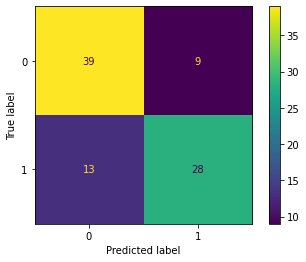

In [20]:
class ColumnSelector(object):

    def transform(self, X):
        df = X.copy()
        columns_hcc = ['BLOODPRESSURE_DIASTOLIC_DIFF_REL', 'BLOODPRESSURE_DIASTOLIC_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN', 'BLOODPRESSURE_DIASTOLIC_MIN', 'BLOODPRESSURE_SISTOLIC_DIFF_REL', 'BLOODPRESSURE_SISTOLIC_MEAN', 'BLOODPRESSURE_SISTOLIC_MEDIAN', 'BLOODPRESSURE_SISTOLIC_MEDIAN', 'BLOODPRESSURE_SISTOLIC_MIN', 'BLOODPRESSURE_SISTOLIC_MIN', 'HEART_RATE_DIFF_REL', 'HEART_RATE_MEAN', 'HEART_RATE_MEDIAN', 'HEART_RATE_MIN', 'HEART_RATE_MEDIAN', 'HEART_RATE_MIN', 'HEART_RATE_MIN', 'OXYGEN_SATURATION_DIFF_REL', 'OXYGEN_SATURATION_MEAN', 'OXYGEN_SATURATION_MEDIAN', 'OXYGEN_SATURATION_MEDIAN', 'OXYGEN_SATURATION_MIN', 'OXYGEN_SATURATION_MIN', 'RESPIRATORY_RATE_DIFF_REL', 'RESPIRATORY_RATE_MEAN', 'RESPIRATORY_RATE_MEDIAN', 'RESPIRATORY_RATE_MEDIAN', 'RESPIRATORY_RATE_MIN', 'RESPIRATORY_RATE_MIN', 'TEMPERATURE_DIFF_REL', 'TEMPERATURE_MEAN', 'TEMPERATURE_MEDIAN', 'TEMPERATURE_MEDIAN', 'TEMPERATURE_MIN', 'TEMPERATURE_MIN', 'HEMOGLOBIN_MEAN', 'NEUTROPHILES_MEAN']
        attributes_suffix = ['DIFF', 'DIFF_REL', 'MAX', 'MEAN', 'MEDIAN', 'MIN']
        vital_signs = ['BLOODPRESSURE_DIASTOLIC', 'BLOODPRESSURE_SISTOLIC', 'HEART_RATE', 'OXYGEN_SATURATION', 'RESPIRATORY_RATE', 'TEMPERATURE']
        vital_signs_columns = [f'{vs}_{attr}'for vs in vital_signs for attr in attributes_suffix]
        blood_results = ['ALBUMIN', 'BE_ARTERIAL', 'BE_VENOUS', 'BIC_ARTERIAL', 'BIC_VENOUS', 'BILLIRUBIN', 'BLAST', 'CALCIUM', 'CREATININ', 'FFA', 'GGT', 'GLUCOSE', 'HEMATOCRITE', 'HEMOGLOBIN', 'INR', 'LACTATE', 'LEUKOCYTES', 'LINFOCITOS', 'NEUTROPHILES', 'P02_ARTERIAL', 'P02_VENOUS', 'PC02_ARTERIAL', 'PC02_VENOUS', 'PCR', 'PH_ARTERIAL', 'PH_VENOUS', 'PLATELETS', 'POTASSIUM', 'SAT02_ARTERIAL', 'SAT02_VENOUS', 'SODIUM', 'TGO', 'TGP', 'TTPA', 'UREA', 'DIMER']
        blood_results_columns = [f'{blood}_MEAN' for blood in blood_results]
        demographic_columns = ['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER']
        preexisting_disease_columns = ['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER']
        final_columns = demographic_columns + preexisting_disease_columns + vital_signs_columns + blood_results_columns
        df = df[final_columns]
        df = df.drop(columns=columns_hcc)
        return df

    def fit(self, X, y=None):
        return self

clf = Pipeline(steps=[
    ('selector', ColumnSelector()),           
    ('classification', RandomForestClassifier(criterion='gini', max_depth=6, max_features=0.30034845148359435, min_samples_leaf=6, min_samples_split=10, n_estimators=185))   
    ])

# clf.fit(x_train, y_train)
train_evaluate_classifier(clf, x, y, x_train, y_train, x_test, y_test)

Foi criada uma classe customizada de _Selector_, onde é escolhida apenas as colunas que foram utilizadas no notebook de ML.

Como chegamos ao mesmo resultado, temos um pipeline validado.

## Modelo final

O modelo final que pode ir a produção possue como dados de treino todos os dados disponíveis.

F1: 0.6981065369243075
             precision    recall  f1-score  support
0             0.901554  0.915789  0.908616      190
1                  0.9  0.883436  0.891641      163
accuracy                          0.900850      353
macro avg     0.900777  0.899613  0.900129      353
weighted avg  0.900837   0.90085  0.900778      353


Pipeline(steps=[('selector',
                 <__main__.ColumnSelector object at 0x7feba1d23ad0>),
                ('classification',
                 RandomForestClassifier(max_depth=6,
                                        max_features=0.30034845148359435,
                                        min_samples_leaf=6,
                                        min_samples_split=10,
                                        n_estimators=185))])

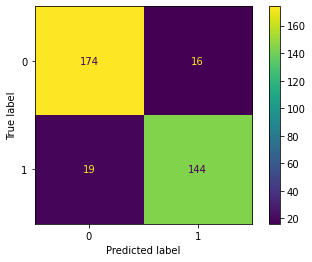

In [13]:
clf_max = train_evaluate_classifier(clf, x, y, x, y, x, y)
clf_max

In [17]:
dump(clf_max, '../model/rfc.model')

['../model/rfc.model']